In [1]:
import warnings
warnings.filterwarnings("ignore")

from config import get_config
from train import train_model, grid_search, get_ds

import torch
import inference_helpers

import json

In [2]:
## randomized search
num_models = 8
best_model_params = []
for k in range(1, num_models+1):
    print(f"MODEL CROSS VALIDATING - #{k}")
    print(20*"--")
    config = get_config()
    config["model_folder"] = "cv_weights"
    config["experiment_name"] = "cv_run/tmodel"
    config["run"] = "cv_run"

    ## hyperparameter tuning
    param_grid = {
            'max_depth': [4, 6, 8, 10],
            'reg_alpha': [0, 0.2, 0.5, 1, 5],
            'reg_lambda': [0, 0.5, 1, 5],
            'subsamaple': [0.5, 0.75, 1]
        }

    config["tgt_step"] = k-1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    search_res = grid_search(config, device, lr_cv = 6*10**-2, n_cv = 300, param_grid = param_grid, n_iter = 120)
    
    best_model_params.append(search_res.best_params_)
    print("Best params:", str(search_res.best_params_))
    print(20*"--")

with open(f"params.json", "w") as outfile: 
    json.dump({"param_grid": param_grid, "best_params": best_model_params}, outfile)

MODEL CROSS VALIDATING - #1
----------------------------------------
Fitting 4 folds for each of 120 candidates, totalling 480 fits
[CV 1/4; 1/120] START max_depth=8, reg_alpha=0.5, reg_lambda=5, subsamaple=0.75.
[CV 1/4; 1/120] END max_depth=8, reg_alpha=0.5, reg_lambda=5, subsamaple=0.75;, score=-20254.592 total time=   4.4s
[CV 2/4; 1/120] START max_depth=8, reg_alpha=0.5, reg_lambda=5, subsamaple=0.75.
[CV 2/4; 1/120] END max_depth=8, reg_alpha=0.5, reg_lambda=5, subsamaple=0.75;, score=-14528.446 total time=   5.0s
[CV 3/4; 1/120] START max_depth=8, reg_alpha=0.5, reg_lambda=5, subsamaple=0.75.
[CV 3/4; 1/120] END max_depth=8, reg_alpha=0.5, reg_lambda=5, subsamaple=0.75;, score=-17470.648 total time=   5.4s
[CV 4/4; 1/120] START max_depth=8, reg_alpha=0.5, reg_lambda=5, subsamaple=0.75.
[CV 4/4; 1/120] END max_depth=8, reg_alpha=0.5, reg_lambda=5, subsamaple=0.75;, score=-12144.013 total time=   5.7s
[CV 1/4; 2/120] START max_depth=6, reg_alpha=5, reg_lambda=1, subsamaple=1......

In [7]:
## Multiple model training
best_score = []
cfg = get_config()
num_models0 = 1
num_models1 = 8

for k in range(num_models0, num_models1+1):
    print(f"MODEL TRAINING - #{k}")
    print(20*"-")
    cfg = get_config()

    cfg["tgt_step"] = k-1
    cfg['run'] += f"_{k}"
    cfg['model_folder'] += cfg['run']
    cfg['experiment_name'] = f"runs{cfg['run']}/tmodel"

    for param_name in param_grid.keys():
        cfg[param_name] = best_model_params[k-1][param_name]

    model = train_model(cfg)
    best_score.append(model.best_score)

    # save config to JSON
    with open(f"{cfg['run']}.json", "w") as outfile: 
        json.dump(cfg, outfile)
    print(20*"-")

MODEL TRAINING - #1
--------------------
Using device: cuda
[0]	validation_0-mae:130.08307	validation_0-rmse:176.45368	validation_1-mae:122.69482	validation_1-rmse:169.85599
[1]	validation_0-mae:127.16930	validation_0-rmse:172.30809	validation_1-mae:119.93185	validation_1-rmse:165.83844
[2]	validation_0-mae:124.51176	validation_0-rmse:168.52253	validation_1-mae:117.41331	validation_1-rmse:162.14170
[3]	validation_0-mae:122.07002	validation_0-rmse:165.05512	validation_1-mae:115.07532	validation_1-rmse:158.76660
[4]	validation_0-mae:119.86552	validation_0-rmse:161.90913	validation_1-mae:112.96610	validation_1-rmse:155.70524
[5]	validation_0-mae:117.88215	validation_0-rmse:159.03336	validation_1-mae:111.08445	validation_1-rmse:152.87661
[6]	validation_0-mae:116.03946	validation_0-rmse:156.39218	validation_1-mae:109.35549	validation_1-rmse:150.28294
[7]	validation_0-mae:114.40301	validation_0-rmse:154.03196	validation_1-mae:107.82313	validation_1-rmse:147.97810
[8]	validation_0-mae:112.886

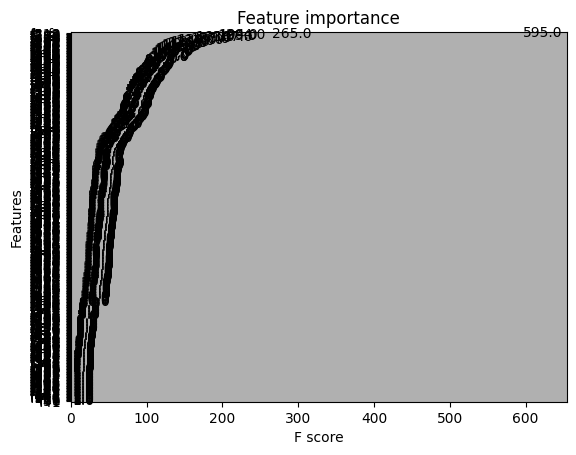

In [9]:
import matplotlib.pyplot as plt

# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

In [8]:
#print(model.get_params())
best_score

[116.8889801180873,
 140.38182816929168,
 149.54330689473042,
 154.72854448447475,
 161.23517344543967,
 164.28992267608376,
 165.36166809123392,
 165.17713374737252]

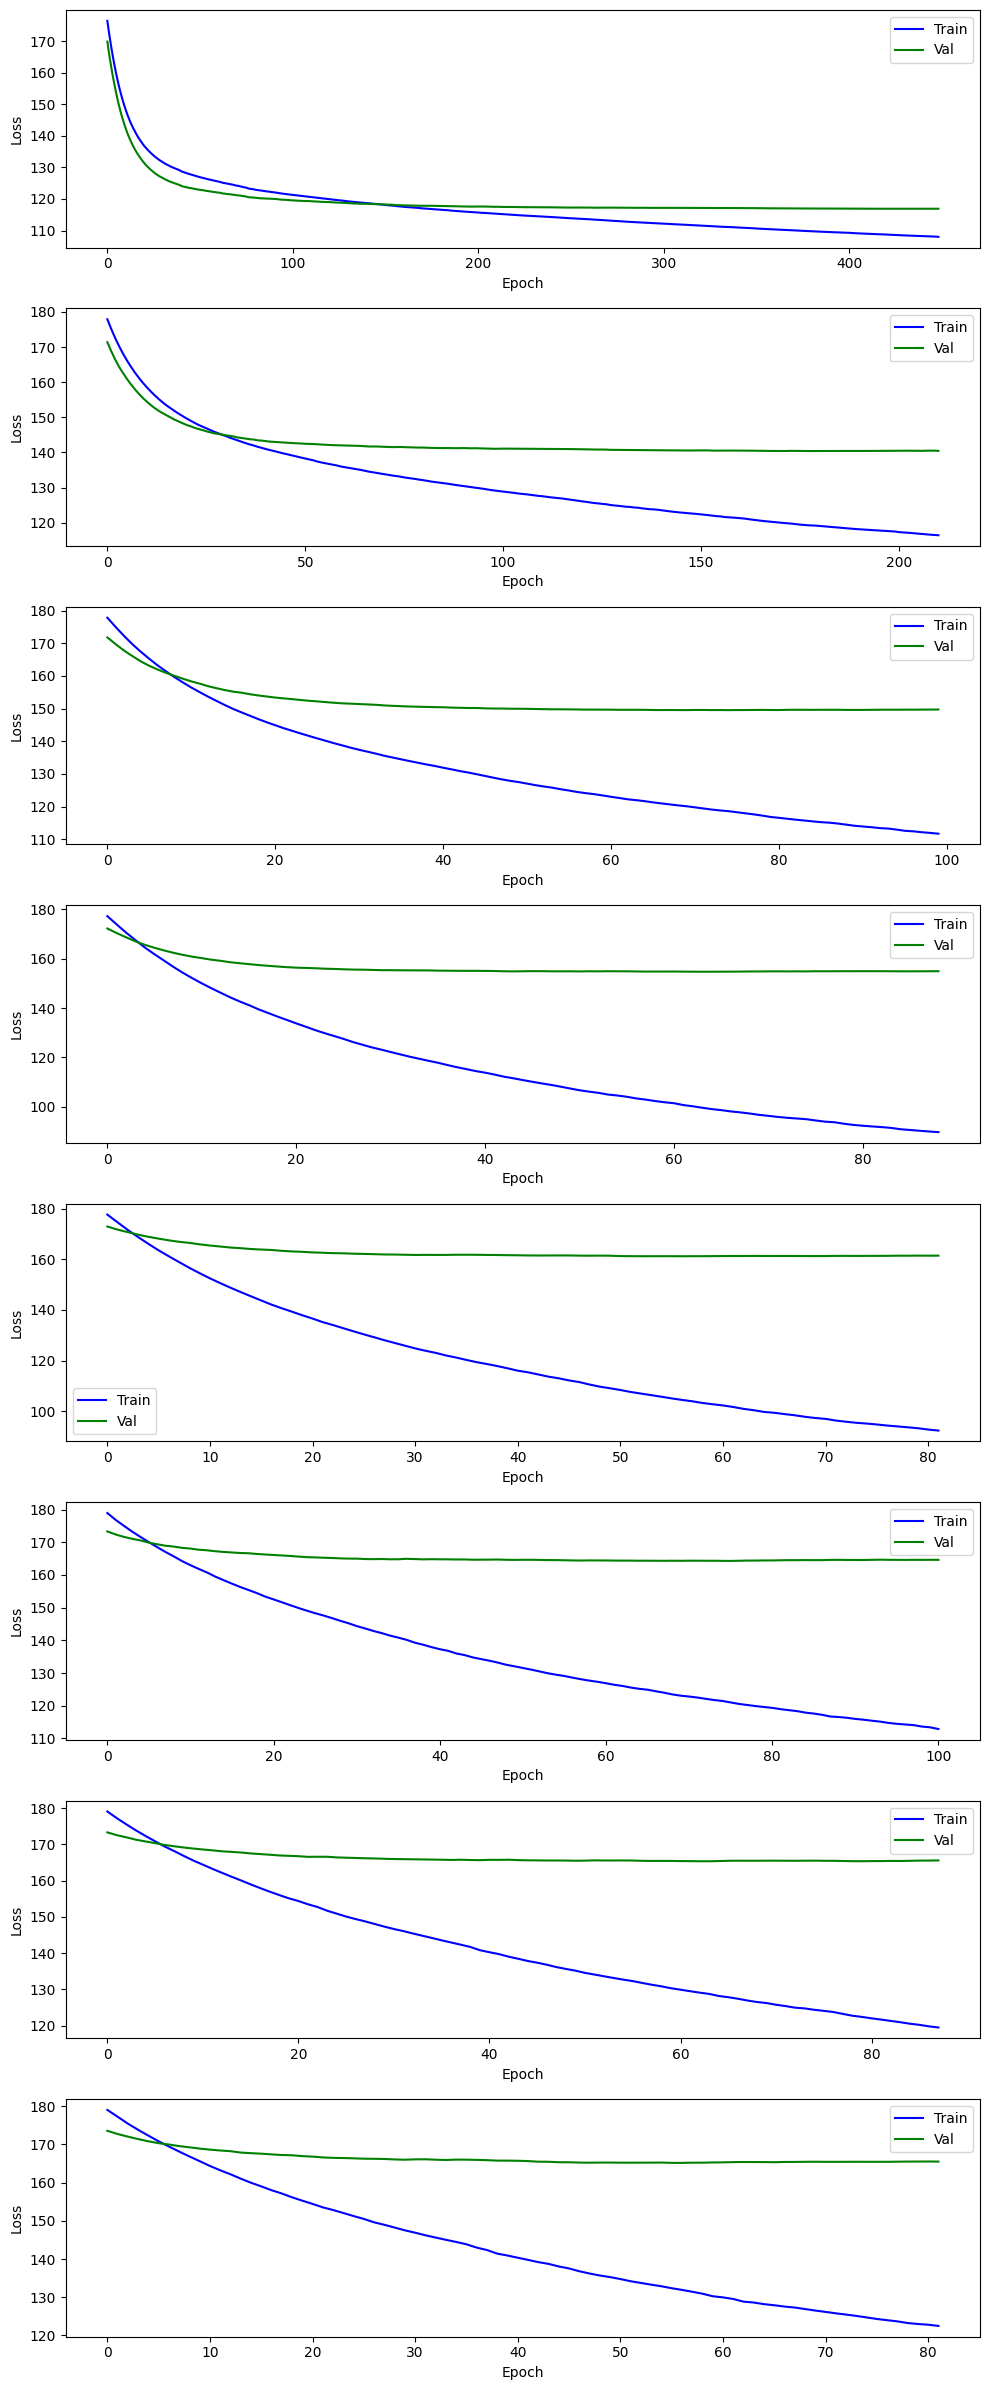

In [10]:
inference_helpers.arrange_figures_in_rows(n_rows=num_models1, prefix="forward_")

In [ ]:
# pozorovani
# -- xgboost vyuziva vsechny stromy k predikci, dohormady davaji nejlepsi
# prediktor az do k-te vrstvy
# -- posledni z eval_metrics se pouziva k early_stopping, takze je treba je usporadat
# -- validacni sada bude potreba k treninku, tudiz musim sehnat i testovaci sadu
# ? mozna bych mohl dostahovat aktualni data